**Part 2 - Computing the PDF**

**A) Theory**

The PDF is the derivative of the CDF, but as the CDF obtained in **Part 1** is discontinuous we are required to take the derivative of $F(y)$ as follows:

- We define a discontinuous piecewise constant function space $V_f \in L^1(\Omega_Y)$ and define the set of basis functions $V_f = span\{\phi_i(y)\}$ such that $f(y) = \sum_i F_i \phi_i(y)$.

- Within each element $\Omega_e$ of $\Omega_Y$, the derivative is given by the slope $\partial_y F_e$. These slopes are assigned are the degrees of freedom of the PDF in each element and so we assign $f_e = \partial_y F_e$.

- At the element facets $\partial \Omega_e$ there is a positive step. The derivative of a Heaviside step function  $\frac{d H(y)}{d y} = \delta(y)$ is a delta function, or more precisely in this case a Dirac measure 
\begin{equation}
\delta(A) = \begin{cases} 1 \quad if A \in \partial \Omega_e \\ 0 \quad \text{otherwise} \end{cases}
\end{equation}
which returns $1$ if $A$ is an element of the set of facets. To account for the size of the step we must multiply the derivative by the jump $F_+ - F_-$ at the facet in question.

**B) Numerical implementation**

To simplify the presentation we use the *NumDF* library (imported below) which implements the methods used in **Part 1**. 

In [54]:
from numdf import Ptp
import numpy as np
from firedrake import *

We begin by creating an instance of the *Ptp* class by specify the physical domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. As justified in Part1 a discontinuous piecewise linear 'DG1' function space is selected by default for the CDF.

In [55]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (-1, 1)}, Omega_Y = {'Y': (-.25, 1)}, n_elements=10)

We then specify our function

\begin{equation}
Y(x_1) = \begin{cases} 0 \quad x_1 < 0 \\ x \quad x_1 \geq 0 \end{cases} 
\end{equation}

in terms of the coordinates of the domain and generate its CDF by calling the fit method.

In [56]:
# Extract the coordinates
x1 = ptp.x_coords()
Y = conditional(ge(x1, 0), x1, 0)
density = ptp.fit(Y=Y, quadrature_degree=50)

Below we plot the CDF, which has intentionally been under-resolved to highlight the two types of discontinuity which can occur. Those arising from the jump in the true CDF and those which arise from using low numerical resolution.

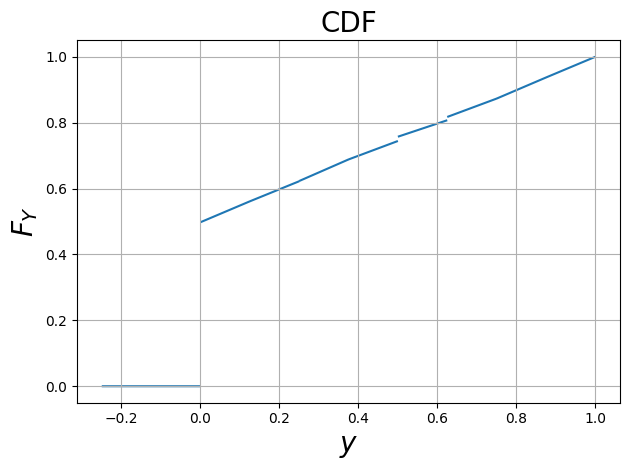

In [57]:
density.plot('CDF')

Reusing the mesh constructed for the CDF $F(y)$ we specify a discontinuous piecewise constant function space $V_f$ for $f(y)$

In [58]:
def compute_pdf(F):
    """Compute the PDF f(y) from the CDF F(y) by taking the derivative
    within the elements and at the element facets separately."""

    # Grab the mesh associated with the CDF
    m_y = F.function_space().mesh()

    # Define a function space for the PDF
    V_f = FunctionSpace(mesh=m_y,family="DG",degree=0);

    # Define th PDF f on this space
    f = Function(V_f)

    # Calculate the slopes within each of element of the CDF F
    slopes = F.dat.data[:].reshape((-1, 2))[:, 1] - F.dat.data[:].reshape((-1, 2))[:, 0]
    y_i = m_y.coordinates.dat.data[::-1]  # Flip as we subtract right coord - left coord
    dy  = y_i[:-1] - y_i[1:]

    # Assign these to the PDF f
    f.dat.data[:] = slopes/dy

    # Compute the jumps between elements
    L = F.dat.data[:].reshape((-1,2))[:,0];
    L = np.hstack((L,[1]))

    R = F.dat.data[:].reshape((-1,2))[:,1];
    R = np.hstack(([0],R))

    jumps = L - R

    # Create a tuple of the jumps and their location
    dirac_measures = {"jump":jumps, "loc":m_y.coordinates.dat.data}

    return f, dirac_measures

f, dirac_measures = compute_pdf(density.cdf)

We then plot the PDF below.

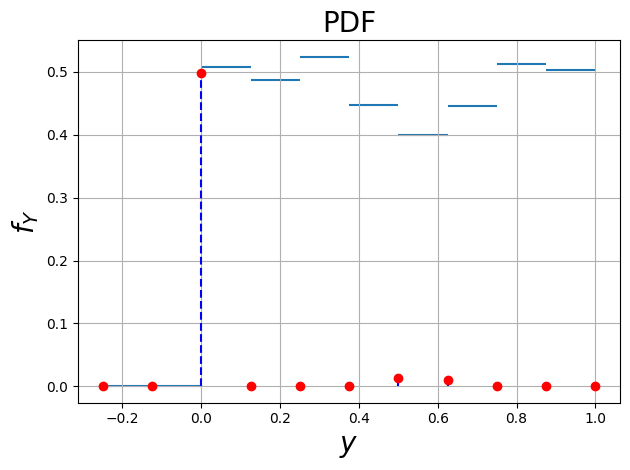

In [59]:
def plot_pdf(f, dirac_measures, dirac=True):
    """Plot the PDF f(y) including the Dirac measures."""

    import matplotlib.pyplot as plt
    from firedrake.pyplot import plot

    # Plot the piecewise constant component
    plot(f,num_sample_points=50)

    # Plot the set of Dirac measures
    if dirac == True:
        y = np.linspace(0,1,50)
        for j_i,y_i in zip(dirac_measures["jump"],dirac_measures["loc"]): 
            plt.plot(y_i*np.ones(50),j_i*y,'b--')
            plt.plot(y_i,j_i,'ro')

    # Label the plot
    plt.title(r'PDF',fontsize=20)
    plt.ylabel(r'$f_Y$',fontsize=20)
    plt.xlabel(r'$y$',fontsize=20)
    plt.tight_layout()
    plt.grid()
    plt.show()

plot_pdf(f, dirac_measures)

To check that mass is conserved we can also integrate the PDF

In [60]:
def integrate_pdf(f,dirac_measures):
    """Integrate the PDF f(y) including the Dirac measures."""

    # Contribution of the elements
    int_f = assemble(f*dx)

    # Contribution of the Dirac measures
    int_f += np.sum(dirac_measures["jump"])
    
    print('Element - int f(y) dy = %e' % assemble(f*dx))
    print('Dirac measure - int f(y) dy = %e' % np.sum(dirac_measures["jump"]))
    print('Total - int f(y) dy = %e' % int_f)
    
    return int_f

When the element boundaries do not coincide with the jumps in the CDF, the approximation is less accurate but mass is still conserved. 

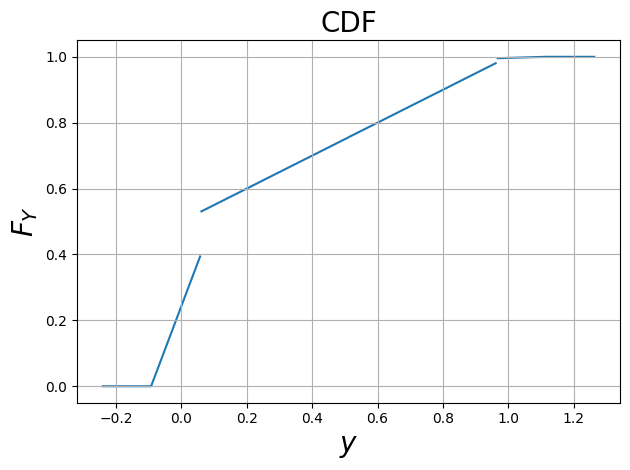

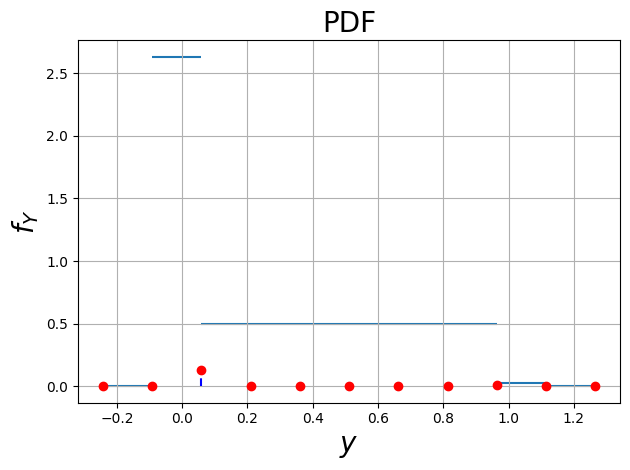

Element - int f(y) dy = 8.531731e-01
Dirac measure - int f(y) dy = 1.468269e-01
Total - int f(y) dy = 1.000000e+00


np.float64(1.0000000000000004)

In [61]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (-1, 1)}, Omega_Y = {'Y': (-.2432, 1.26584)}, n_elements=10)

# Extract the coordinates
x1 = ptp.x_coords()
Y = conditional(ge(x1, 0), x1, 0)
density = ptp.fit(Y=Y, quadrature_degree=500)

density.plot('CDF')

f, dirac_measures = compute_pdf(density.cdf)

plot_pdf(f, dirac_measures, dirac=True)

integrate_pdf(f, dirac_measures)